## PCA with linear models

As we saw during the EDA after PCA tranformation our target variable seemed to depend lineary of the principal components.

So why don't we do the first modelling according to our results of the exploration?
Let's try to implement simple linear models with PCA transformation.

Of course we will do that on our cleared data without the outliers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib as mpl
import seaborn as sns
from IPython.core.display import HTML
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression

In [2]:
data = pd.read_csv("data/train_without_nans.csv")
data_sub = pd.read_csv("data/test_without_nans.csv")

encoded = pd.read_csv("data/encoded_train.csv")
encoded_sub = pd.read_csv("data/encoded_test.csv")

cleared = pd.read_csv("data/cleared_train.csv")

## Content

## Data Transformation

Let's transform our train and submission data using PCA

In [3]:
continuous_columns = ['LotFrontage', 'LotArea', 'OverallQual', 
                      'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                      'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                      '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                      'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                      'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
                      'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                      'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

'''
    Scaling the cleared train data and then sub 
    data based on the cleared data scaling parameters
'''
scaled = cleared.copy() 
scaled_sub = encoded_sub.copy()

scaler = StandardScaler()

scaled[continuous_columns] = scaler.fit_transform(scaled[continuous_columns])
scaled_sub[continuous_columns] = scaler.transform(scaled_sub[continuous_columns])

scaled["SalePrice"] = np.log(scaled["SalePrice"])

'''
    Transforming the scaled train data and then 
    scaled sub data based on the scaled train
    transformation parameters
'''

pca = PCA(n_components = 50, random_state=1)

reduced = scaled.drop(["SalePrice"], axis=1)
reduced = pd.DataFrame(pca.fit_transform(reduced),
                       columns=["pc{}".format(i) for i in range(1, 51)])
reduced["SalePrice"] = scaled["SalePrice"]

reduced_sub = pd.DataFrame(pca.transform(scaled_sub),
                           columns=["pc{}".format(i) for i in range(1, 51)])

In [4]:
reduced.shape, reduced_sub.shape

((1410, 51), (1459, 50))

## Visualization

To ensure that the transformation was made correctly and that we received something like in EDA

In [6]:
fig = px.scatter_3d(reduced, x="pc1", y="pc2", z="SalePrice", color="SalePrice")
fig.update_traces(marker_size = 2)
fig.show()

## PCA decorrelating effect

PCA has a very usefull property. Features, created by PCA are uncorrelated. That means that we can use simple Linear Regression for our data and don't be afraid that we can receive some large model coefficients because of the multicollinearity problem. We can ensure in this by taking corr() method in our reduced data

<Axes: >

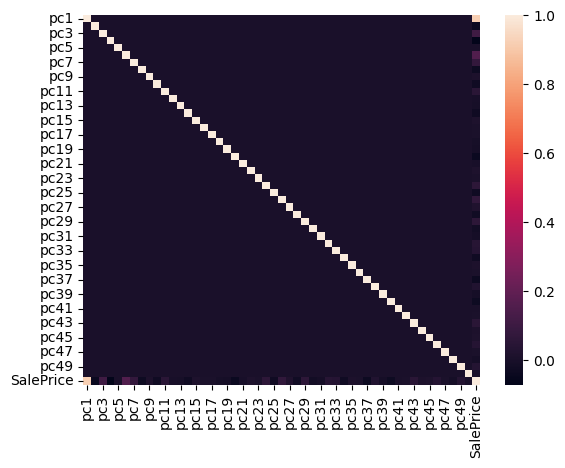

In [7]:
sns.heatmap(reduced.corr())

## Train/Test split and model applying

Let's take a look how Linear Regression performs on our data

In [9]:
X = reduced.drop(["SalePrice"], axis=1).copy()
y = reduced["SalePrice"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

lr_reg = LinearRegression().fit(X_train, y_train)

real_y_train = np.exp(y_train)
real_y_test = np.exp(y_test)

train_pred = lr_reg.predict(X_train)
test_pred = lr_reg.predict(X_test)

print("TRAIN LOG RMSE:", root_mean_squared_error(y_train, train_pred))
print("TEST LOG RMSE:", root_mean_squared_error(y_test, test_pred))
print("." * 35)
print("TRAIN RMSE", root_mean_squared_error(real_y_train, np.exp(train_pred)))
print("TEST RMSE", root_mean_squared_error(real_y_test, np.exp(test_pred)))

TRAIN LOG RMSE: 0.10282163263721619
TEST LOG RMSE: 0.11387680505390109
...................................
TRAIN RMSE 20103.93597943525
TEST RMSE 20406.41694908872


We received bigger train loss than for example with Ridge regression in our base modeling. BUT we received also lower test loss.

### Checking coefficients

In [10]:
sorted_coef_idx = np.argsort(-np.abs(lr_reg.coef_))
coef = lr_reg.coef_[sorted_coef_idx]
for i in range(0, 5):
    print("{:.<025} {:< }".format(X_train.columns[sorted_coef_idx[i]], coef[i]))

pc1......................  0.11742682024011104
pc6......................  0.04847886534268679
pc26.....................  0.03367873496772156
pc46.....................  0.032633304709246753
pc29.....................  0.028799150231651582
